<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Network_regression_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [0]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_targets = df_train.Surv_time_months

In [0]:
test_targets = df_test.Surv_time_months

#Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [0]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [0]:
train_data_stand_pca.shape

(131, 9)

#Building Network

In [0]:
from keras import models

In [0]:
from keras import layers

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(5, activation='relu', input_shape=(9,)))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

#K-Fold

In [0]:
from sklearn.model_selection import KFold

In [0]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
kf.get_n_splits(train_data_stand_pca, train_targets)

3

In [0]:
for train_index, test_index in kf.split(train_data_stand_pca, train_targets):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   3   6   7   8   9  10  11  13  14  15  16  18  19  20  21  22
  23  24  25  26  27  28  29  30  32  34  36  37  38  39  41  43  47  49
  50  52  57  60  61  63  64  65  67  68  69  70  71  72  74  76  77  78
  79  81  83  84  86  87  88  90  92  94  95  96  99 100 101 103 105 106
 107 108 109 112 113 115 117 119 120 122 123 125 127 129 130] TEST: [  2   4   5  12  17  31  33  35  40  42  44  45  46  48  51  53  54  55
  56  58  59  62  66  73  75  80  82  85  89  91  93  97  98 102 104 110
 111 114 116 118 121 124 126 128]
TRAIN: [  0   1   2   4   5   6   7   8   9  11  12  13  14  16  17  18  20  22
  25  28  29  31  33  35  37  40  42  44  45  46  48  50  51  53  54  55
  56  57  58  59  60  61  62  63  64  66  68  71  72  73  75  76  79  80
  81  82  84  85  86  87  88  89  91  93  94  96  97  98 101 102 104 105
 106 107 109 110 111 114 116 117 118 119 121 124 125 126 128] TEST: [  3  10  15  19  21  23  24  26  27  30  32  34  36  38  39  41  43  47
  49  52  65 

In [0]:
num_epochs = 100
all_mae_histories = []
all_mae_val_histories = []
all_loss_histories = []
all_loss_val_histories = []

for train_index, val_index in kf.split(train_data_stand_pca, train_targets):
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_targets[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_targets[i] for i in val_index])

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), 
                      epochs= num_epochs, batch_size=1)
  
  mae_history = history.history['mean_absolute_error']
  all_mae_histories.append(mae_val_history)

  mae_val_history = history.history['val_mean_absolute_error']
  all_mae_val_histories.append(mae_val_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  loss_val_history = history.history['val_loss']
  all_loss_val_histories.append(loss_val_history)


Train on 87 samples, validate on 44 samples
Epoch 1/100
87/87 [==============================] - 2s 18ms/step - loss: 818.7472 - mean_absolute_error: 22.3612 - val_loss: 535.5238 - val_mean_absolute_error: 17.0611
Epoch 2/100
87/87 [==============================] - 0s 1ms/step - loss: 782.9275 - mean_absolute_error: 21.7816 - val_loss: 517.1099 - val_mean_absolute_error: 16.6151
Epoch 3/100
87/87 [==============================] - 0s 2ms/step - loss: 750.2949 - mean_absolute_error: 21.2044 - val_loss: 499.4825 - val_mean_absolute_error: 16.1766
Epoch 4/100
87/87 [==============================] - 0s 1ms/step - loss: 719.7357 - mean_absolute_error: 20.6690 - val_loss: 482.6389 - val_mean_absolute_error: 15.7378
Epoch 5/100
87/87 [==============================] - 0s 1ms/step - loss: 688.6146 - mean_absolute_error: 20.1393 - val_loss: 466.6482 - val_mean_absolute_error: 15.3156
Epoch 6/100
87/87 [==============================] - 0s 1ms/step - loss: 660.9132 - mean_absolute_error: 19.66

In [0]:
history_dict = history.history

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [0]:
average_mae_val_history = [np.mean([x[i] for x in all_mae_val_histories]) for i in range(num_epochs)]
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_loss_val_history = [np.mean([x[i] for x in all_loss_val_histories]) for i in range(num_epochs)]
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

#Plotting training and validation mae

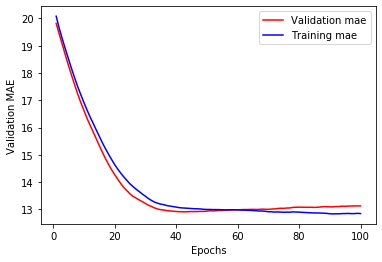

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_val_history) + 1), average_mae_val_history, 'r', label='Validation mae')
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history, 'b', label='Training mae')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()


#Plotting training and validation loss

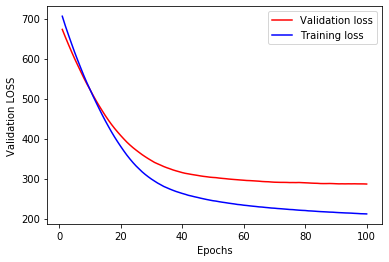

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_loss_val_history) + 1), average_loss_val_history, 'r', label='Validation loss')
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, 'b', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Validation LOSS')
plt.legend()
plt.show()